In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay
from typing import Optional, Union, Callable

In [2]:
MACHS = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
EXTENSIONS = [0,0.005086,0.010172,0.015258,0.020344,0.02543]
DATA_SHAPE = (len(MACHS), len(EXTENSIONS))

LOWER_PRESSURE = 70
HIGHER_PRESSURE = 101.325

LOWER_PRESSURE_FILE = "70_drag.csv"
HIGHER_PRESSURE_FILE = "101_drag.csv"

MACH_LABEL = "mach"
EXTENSION_LABEL = "extension"
DRAG_LABEL = "drag"

LOWER_PRESSURE_LABEL = "lower_pressure"
HIGHER_PRESSURE_LABEL = "higher_pressure"

In [3]:
DATA_SHAPE

(16, 6)

In [4]:
def read_data(file: str, series: Optional[bool] = False) -> Union[pd.DataFrame, pd.Series]:
    data = pd.read_csv(file, header=None)
    data.columns = EXTENSIONS
    data.index = MACHS

    data = data.stack().rename(DRAG_LABEL)
    data.index.names = [MACH_LABEL, EXTENSION_LABEL]
    return data if series else data.reset_index()

def plot_data(*data: pd.DataFrame) -> None:
    trisurfs = []
    for df in data:
        points_2d = np.vstack([df[EXTENSION_LABEL], df[MACH_LABEL]]).T
        simplices = Delaunay(points_2d).simplices
        trisurfs += ff.create_trisurf(df[EXTENSION_LABEL], df[MACH_LABEL], df[DRAG_LABEL], 
                                      show_colorbar=not bool(trisurfs), simplices=simplices).data
    
    fig = go.Figure(data=trisurfs)
    fig.update_layout(width=800, height=600)
    fig.update_scenes(
        xaxis_title_text=EXTENSION_LABEL, 
        yaxis_title_text=MACH_LABEL, 
        zaxis_title_text=DRAG_LABEL)
    
    fig.show()

In [5]:
lower_pressure_data = read_data(LOWER_PRESSURE_FILE)
lower_pressure_data.to_csv("lower_pressure_processed.csv", index=False)

In [6]:
higher_pressure_data = read_data(HIGHER_PRESSURE_FILE)
higher_pressure_data.to_csv("higher_pressure_processed.csv", index=False)

In [7]:
pressure_data = pd.merge(lower_pressure_data, higher_pressure_data, how="inner",
                         suffixes=(f"_{LOWER_PRESSURE_LABEL}", f"_{HIGHER_PRESSURE_LABEL}"),
                         left_on=[MACH_LABEL, EXTENSION_LABEL],
                         right_on=[MACH_LABEL, EXTENSION_LABEL])
pressure_data

,mach,extension,drag_lower_pressure,drag_higher_pressure
0,0.05,0.000000,0.721123,0.986143
1,0.05,0.005086,0.734851,1.007613
2,0.05,0.010172,0.785478,1.088461
3,0.05,0.015258,0.863948,1.198790
4,0.05,0.020344,0.941864,1.320181
...,...,...,...,...
91,0.80,0.005086,137.227384,193.243124
92,0.80,0.010172,157.986312,223.065500
93,0.80,0.015258,179.677388,254.888716
94,0.80,0.020344,201.482804,292.228984


In [13]:
MachExtensionPair = tuple[float, float]
PressureToDragFunc = Callable[[float], float]
pressure_to_drag: dict[MachExtensionPair, PressureToDragFunc] = {}

def fit_linear_model(lower_pressure: float, higher_pressure: float,
                    drag_lower_pressure: float, drag_higher_pressure: float) -> PressureToDragFunc:

    def linear_model(pressure: float) -> float:
        slope = (drag_higher_pressure - drag_lower_pressure) / (higher_pressure - lower_pressure)
        drag = slope * (pressure - higher_pressure) + drag_higher_pressure
        return drag
    
    return linear_model

for _, row in pressure_data.iterrows():
    mach_extension_pair = (row[MACH_LABEL], row[EXTENSION_LABEL])
    drag_lower_pressure = row[f"{DRAG_LABEL}_{LOWER_PRESSURE_LABEL}"]
    drag_higher_pressure = row[f"{DRAG_LABEL}_{HIGHER_PRESSURE_LABEL}"]
    pressure_to_drag[mach_extension_pair] = fit_linear_model(LOWER_PRESSURE, HIGHER_PRESSURE, drag_lower_pressure, drag_higher_pressure)

In [14]:
def calculate_drag(mach: float, extension: float, pressure: float) -> float:
    mach_extension_pair = (mach, extension)
    if mach_extension_pair not in pressure_to_drag:
        raise RuntimeError("Invalid mach and extension pair.")
    return pressure_to_drag[mach_extension_pair](pressure)

calculate_drag(mach=0.3, extension=0.005086, pressure=101)

30.6038596

In [19]:
SAMPLES = 10000
MIN_PRESSURE = 50
MAX_PRESSURE = 100

mach_train = []
extension_train = []
pressure_train = []
drag_train = []

for mach, extension in zip(MACHS, EXTENSIONS):
    pressures = np.random.uniform(MIN_PRESSURE, MAX_PRESSURE, SAMPLES)
    for pressure in pressures:
        mach_train.append(mach)
        extension_train.append(extension)
        pressure_train.append(pressure)
        drag_train.append(calculate_drag(mach, extension, pressure))

X = pd.DataFrame({"mach": mach_train, "extension": extension_train, "pressure": pressure_train})
y = pd.Series(drag_train)

In [20]:
X

,mach,extension,pressure
0,0.30,0.00000,69.120717
1,0.30,0.00000,93.224608
2,0.30,0.00000,99.657630
3,0.30,0.00000,79.554655
4,0.30,0.00000,98.869573
...,...,...,...
59995,0.55,0.02543,90.195052
59996,0.55,0.02543,70.574576
59997,0.55,0.02543,72.164999
59998,0.55,0.02543,51.600169


In [21]:
y

0         21.127767
1         27.231174
2         28.860095
3         23.769771
4         28.660549
            ...    
59995    149.434567
59996    119.410970
59997    121.844663
59998     90.376000
59999    113.864973
Length: 60000, dtype: float64

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [23]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [57]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [58]:
input_size = 3
hidden_size = 64
output_size = 1
learning_rate = 0.05
num_epochs = 2000

model = NeuralNet(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [59]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/2000], Loss: 1245.7410
Epoch [200/2000], Loss: 865.5724
Epoch [300/2000], Loss: 288.6269
Epoch [400/2000], Loss: 92.9055
Epoch [500/2000], Loss: 66.5195
Epoch [600/2000], Loss: 32.4154
Epoch [700/2000], Loss: 24.0039
Epoch [800/2000], Loss: 16.8289
Epoch [900/2000], Loss: 15.7643
Epoch [1000/2000], Loss: 15.6941
Epoch [1100/2000], Loss: 13.4208
Epoch [1200/2000], Loss: 29.6157
Epoch [1300/2000], Loss: 5.6706
Epoch [1400/2000], Loss: 8.2172
Epoch [1500/2000], Loss: 20.9137
Epoch [1600/2000], Loss: 9.4531
Epoch [1700/2000], Loss: 19.1247
Epoch [1800/2000], Loss: 11.7154
Epoch [1900/2000], Loss: 6.0398
Epoch [2000/2000], Loss: 5.2186


Mean Squared Error: 6.032961
R-squared Score: 0.9957799532054289


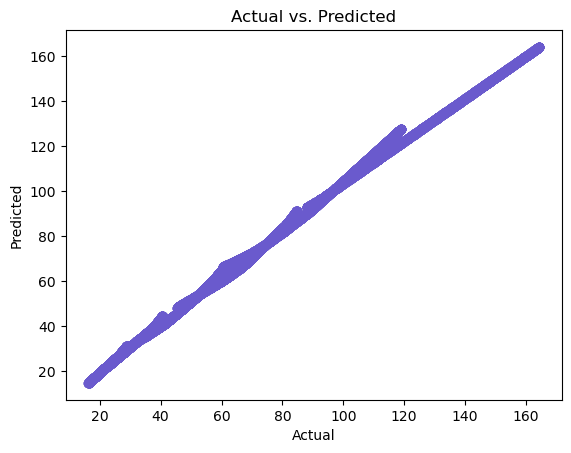

In [61]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Convert predictions and ground truth to numpy arrays
y_pred = y_pred.flatten()  # Flatten predictions
y_test_numpy = y_test_tensor.numpy().flatten()  # Flatten ground truth

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test_numpy, y_pred)
r2 = r2_score(y_test_numpy, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Optionally, you can plot the predicted vs. actual values
import matplotlib.pyplot as plt

plt.scatter(y_test_numpy, y_pred, color='slateblue')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [17]:
Fit Name: lower
x = mach, y = extension
Polynomial Surface Fit (poly22)
f(x,y) = 15.9894 - 81.7799 * x -1.7041e+03 *y + 280.5132*x^2 + 6.2419e+03*x*y + 2.7922e+04*y^2

Coefficients and 95% Confidence Bounds
          Value          Lower          Upper    
p00    15.9894        11.7261        20.2528    
p10    -81.7799       -99.2145       -64.3453   
p01    -1.7041e+03    -2.1158e+03    -1.2923e+03
p20    280.5132       261.6525       299.3738   
p11    6.2419e+03     5.7969e+03     6.6869e+03 
p02    2.7922e+04     1.4115e+04     4.1729e+04 

Goodness of Fit
              Value    
SSE         1.7375e+03
R-square    0.9949    
DFE         90        
Adj R-sq    0.9946    
RMSE        4.3938    

SyntaxError: invalid syntax (4185352727.py, line 1)

In [ ]:
Fit Name: lower_FULL_MACH2

Polynomial Surface Fit (poly33)
f(x,y) = 68.2243 -668.2799*x -1.1397e+03*y + 1.3993e+03*x^2 + 1.3374e+04*x*y + 8.1616e+04 *y^2 -349.7704*x^3 -3.3397e+04*x^2*y + 6.5648e+05*x*y^2 -7.5125e+06*y^3

Coefficients and 95% Confidence Bounds
          Value          Lower          Upper    
p00    68.2243        25.3050        111.1435   
p10    -668.2799      -845.8930      -490.6669  
p01    -1.1397e+03    -9.6864e+03    7.4069e+03 
p20    1.3993e+03     1.1963e+03     1.6023e+03 
p11    1.3374e+04     -3.7717e+03    3.0521e+04 
p02    8.1616e+04     -5.7309e+05    7.3632e+05 
p30    -349.7704      -415.8129      -283.7279  
p21    -3.3397e+04    -4.4977e+04    -2.1817e+04
p12    6.5648e+05     2.1290e+05     1.1001e+06 
p03    -7.5125e+06    -2.3535e+07    8.5100e+06 

Goodness of Fit
              Value    
SSE         1.3098e+05
R-square    0.9929    
DFE         110       
Adj R-sq    0.9924    
RMSE        34.5064   

In [ ]:
Fit Name: higher

Polynomial Surface Fit (poly22)
f(x,y) = 23.6982 -123.4344*x - 2.5545e+03*y + 402.1042*x^2 + 9.1165e+03*x*y + 4.4646e+04*y^2

Coefficients and 95% Confidence Bounds
          Value          Lower          Upper    
p00    23.6982        17.5978        29.7986    
p10    -123.4344      -148.3817      -98.4871   
p01    -2.5545e+03    -3.1437e+03    -1.9653e+03
p20    402.1042       375.1164       429.0920   
p11    9.1165e+03     8.4797e+03     9.7532e+03 
p02    4.4646e+04     2.4889e+04     6.4403e+04 

Goodness of Fit
              Value    
SSE         3.5575e+03
R-square    0.9948    
DFE         90        
Adj R-sq    0.9945    
RMSE        6.2871    

In [28]:
def f(x,y):
    return 15.9894 - 81.7799 * x -1.7041e+03 *y + 280.5132*x**2 + 6.2419e+03*x*y + 2.7922e+04*y**2

In [29]:
f(1.0, 0.02543)

348.17568977779996